# Open-Unmix: Audio Source Separation

In [1]:
# Imports and setup

import os
import glob
import json

import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.stats import kruskal, mannwhitneyu

import musdb
import museval
import torch, torchaudio

import openunmix.predict as openunmix

from demucs.pretrained import get_model
from demucs.apply import apply_model
from demucs.audio import convert_audio

from asteroid.models import XUMX

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("CUDA device:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("Could not get CUDA device name:", e)
else:
    print("Using CPU")

CUDA available: False
Using CPU


In [9]:
# Paths
path_to_folder = "."
musdb_root = os.path.join(path_to_folder, "musdb18")
estimates_base_path = os.path.join(path_to_folder, "estimates")
output_base_path = os.path.join(path_to_folder, "output")
pretrained_models_path = os.path.join(path_to_folder, "pretrained_models")

# Ensure directories exist
os.makedirs(estimates_base_path, exist_ok=True)
os.makedirs(output_base_path, exist_ok=True)
os.makedirs(pretrained_models_path, exist_ok=True)
!ls

estimates  music_separator.ipynb  output_from_home   requirements.txt
musdb18    output		  pretrained_models  spleeter.ipynb


In [6]:
# Load MUSDB dataset
mus = musdb.DB(
    root=musdb_root,
    download=True,
    subsets="test",
)

100%|██████████| 140M/140M [01:03<00:00, 2.32MB/s] 


In [7]:
# --- SETTINGS ---
model_name = "openunmix"
targets = ["vocals"]  # or ["vocals", "drums", "bass", "other"]
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- PATHS ---
estimates_path = os.path.join(estimates_base_path, model_name)
output_path = os.path.join(output_base_path, model_name)
os.makedirs(estimates_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

# --- CREATE TRACK SUBDIRECTORIES BEFORE SEPARATION ---
for track in mus:
    track_path = os.path.join(estimates_path, "test", track.name)
    os.makedirs(track_path, exist_ok=True)

print(f"[✓] Created subdirectories for all {len(mus)} tracks.")

# --- SEPARATION LOOP ---
for track in mus:
    print(f"[→] Separating: {track.name}")

    track_path = os.path.join(estimates_path, "test", track.name)

    # Skip if target already exists
    out_file = f"{targets[0]}.wav"
    if os.path.exists(os.path.join(track_path, out_file)):
        print("   ↳ Already exists, skipping.")
        continue

    # Load audio and separate
    audio = torch.tensor(track.audio.T).float().to(device)  # (2, samples)
    estimates = openunmix.separate(
        audio=audio,
        rate=track.rate,
        targets=targets,
        residual=True,
        device=device,
    )

    # Rename residual -> accompaniment
    if "residual" in estimates:
        estimates["accompaniment"] = estimates.pop("residual")

    # --- Save separated stems ---
    for target, audio_tensor in estimates.items():
        audio_np = np.squeeze(audio_tensor.detach().cpu().numpy().T)
        out_file = f"{target}.wav"
        out_path = os.path.join(track_path, out_file)
        sf.write(out_path, audio_np, track.rate)

print("\n[✓] Separation finished.")

# --- EVALUATION ---
print("\n[✓] Evaluating using museval.eval_mus_dir...")

eval_results = museval.eval_mus_dir(
    dataset=mus,
    estimates_dir=os.path.join(estimates_path),
    output_dir=output_path,
    ext="wav",
)

print("[✓] Evaluation complete.")

[✓] Created subdirectories for all 50 tracks.
[→] Separating: AM Contra - Heart Peripheral
Downloading: "https://zenodo.org/records/5069601/files/vocals-bccbd9aa.pth" to /home/teraflops/.cache/torch/hub/checkpoints/vocals-bccbd9aa.pth


100%|██████████| 108M/108M [00:54<00:00, 2.09MB/s] 


[→] Separating: Al James - Schoolboy Facination
[→] Separating: Angels In Amplifiers - I'm Alright
[→] Separating: Arise - Run Run Run
[→] Separating: BKS - Bulldozer
[→] Separating: BKS - Too Much
[→] Separating: Ben Carrigan - We'll Talk About It All Tonight
[→] Separating: Bobby Nobody - Stitch Up
[→] Separating: Buitraker - Revo X
[→] Separating: Carlos Gonzalez - A Place For Us
[→] Separating: Cristina Vane - So Easy
[→] Separating: Detsky Sad - Walkie Talkie
[→] Separating: Enda Reilly - Cur An Long Ag Seol
[→] Separating: Forkupines - Semantics
[→] Separating: Georgia Wonder - Siren
[→] Separating: Girls Under Glass - We Feel Alright
[→] Separating: Hollow Ground - Ill Fate
[→] Separating: James Elder & Mark M Thompson - The English Actor
[→] Separating: Juliet's Rescue - Heartbeats
[→] Separating: Little Chicago's Finest - My Own
[→] Separating: Louis Cressy Band - Good Time
[→] Separating: Lyndsey Ollard - Catching Up
[→] Separating: M.E.R.C. Music - Knockout
[→] Separating: M

In [7]:
# --- SETTINGS ---
model_name = "htdemucs"
targets = ["vocals"]  # We'll map other sources to accompaniment
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- PATHS ---
estimates_path = os.path.join(estimates_base_path, model_name)
output_path = os.path.join(output_base_path, model_name)
os.makedirs(estimates_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

# --- CREATE TRACK SUBDIRECTORIES BEFORE SEPARATION ---
for track in mus:
    track_path = os.path.join(estimates_path, track.subset, track.name)
    os.makedirs(track_path, exist_ok=True)

print(f"[✓] Created subdirectories for all {len(mus)} tracks ({model_name}).")

# --- LOAD MODEL ---
demucs_model = get_model("htdemucs")
demucs_model.to(device)

# --- SEPARATION LOOP ---
for track in mus:
    print(f"[→] Separating: {track.name}")

    track_path = os.path.join(estimates_path, track.subset, track.name)
    out_file = f"{targets[0]}.wav"
    if os.path.exists(os.path.join(track_path, out_file)):
        print("   ↳ Already exists, skipping.")
        continue

    # Prepare audio for demucs (expects shape: batch, channels, samples)
    audio = torch.tensor(track.audio.T).float().unsqueeze(0)  # shape (1, 2, samples)
    audio = audio.to(device)
    rate = track.rate
    subset = track.subset

    # Convert audio to model's expected sample rate if needed
    audio = convert_audio(audio, rate, demucs_model.samplerate, demucs_model.audio_channels)

    # Apply separation
    with torch.no_grad():
        sources = apply_model(demucs_model, audio, device=device)

    # Remove batch dimension from sources
    sources = sources.squeeze(0)  # Now shape: (n_sources, channels, samples)

    # Map demucs sources to vocals/accompaniment
    estimates = {}
    source_names = demucs_model.sources

    for i, source_name in enumerate(source_names):
        if source_name == "vocals":
            estimates["vocals"] = sources[i]
        else:
            # accumulate non-vocal sources into accompaniment
            if "accompaniment" not in estimates:
                estimates["accompaniment"] = sources[i].clone()
            else:
                estimates["accompaniment"] += sources[i]

    # If no vocals found, create accompaniment from all sources
    if "accompaniment" not in estimates:
        estimates["accompaniment"] = sources.sum(dim=0) - estimates.get("vocals", 0)

    # Convert back to original sample rate if needed
    for key in list(estimates.keys()):
        if demucs_model.samplerate != rate:
            estimates[key] = torchaudio.functional.resample(estimates[key], demucs_model.samplerate, rate)

    # Prepare estimates for evaluation and saving
    cpu_estimates = {
        key: torch.squeeze(value).detach().cpu().numpy().T  # shape (samples, 2)
        for key, value in estimates.items()
    }

    # Save separated audio files
    for target, audio_tensor in estimates.items():
        audio_np = torch.squeeze(audio_tensor).detach().cpu().numpy().T  # shape (samples, 2)
        out_file = f"{target}.wav"
        out_path = os.path.join(track_path, out_file)
        sf.write(out_path, audio_np, rate)

print("\n[✓] Separation finished for HTDemucs.")

# --- EVALUATION ---
print("\n[✓] Evaluating using museval.eval_mus_dir...")

eval_results = museval.eval_mus_dir(
    dataset=mus,
    estimates_dir=os.path.join(estimates_path),
    output_dir=output_path,
    ext="wav",
)

print("[✓] Evaluation complete.")

[✓] Created subdirectories for all 50 tracks (htdemucs).
[→] Separating: AM Contra - Heart Peripheral
[→] Separating: AM Contra - Heart Peripheral


MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 49533120, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 49533120, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 193536, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 193536, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 24766848, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [EvaluateInvokers] Solver <GemmFwdRest>, workspace required: 24766848, provided ptr: 0 size: 0
MIOpen(HIP): Warning [IsEnoughWorkspace] [GetSolutionsFallback WTI] Solver <GemmFwdRest>, workspace required: 387072, provided ptr: 0 size: 0
MIOpen(HIP): Warning [

[→] Separating: Al James - Schoolboy Facination
[→] Separating: Angels In Amplifiers - I'm Alright
[→] Separating: Angels In Amplifiers - I'm Alright
[→] Separating: Arise - Run Run Run
[→] Separating: Arise - Run Run Run
[→] Separating: BKS - Bulldozer
[→] Separating: BKS - Bulldozer
[→] Separating: BKS - Too Much
[→] Separating: BKS - Too Much
[→] Separating: Ben Carrigan - We'll Talk About It All Tonight
[→] Separating: Ben Carrigan - We'll Talk About It All Tonight
[→] Separating: Bobby Nobody - Stitch Up
[→] Separating: Bobby Nobody - Stitch Up
[→] Separating: Buitraker - Revo X
[→] Separating: Buitraker - Revo X
[→] Separating: Carlos Gonzalez - A Place For Us
[→] Separating: Carlos Gonzalez - A Place For Us
[→] Separating: Cristina Vane - So Easy
[→] Separating: Cristina Vane - So Easy
[→] Separating: Detsky Sad - Walkie Talkie
[→] Separating: Detsky Sad - Walkie Talkie
[→] Separating: Enda Reilly - Cur An Long Ag Seol
[→] Separating: Enda Reilly - Cur An Long Ag Seol
[→] Separa

In [16]:
# --- SETTINGS ---
model_name = "x-umx-asteroid"
targets = ["vocals"]
device = "cuda" if torch.cuda.is_available() else "cpu"
# --- Allow older numpy scalar objects to be unpickled safely ---
torch.serialization.add_safe_globals([np._core.multiarray.scalar])

# --- PATHS ---
# model_path = os.path.join(pretrained_models_path, "pretrained_xumx.pth")
estimates_path = os.path.join(estimates_base_path, model_name)
output_path = os.path.join(output_base_path, model_name)
os.makedirs(estimates_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

# --- CREATE TRACK SUBDIRECTORIES BEFORE SEPARATION ---
for track in mus:
    track_path = os.path.join(estimates_path, track.subset, track.name)
    os.makedirs(track_path, exist_ok=True)

print(f"[✓] Created subdirectories for all {len(mus)} tracks ({model_name}).")

# --- LOAD MODEL ---
x_umx_model = XUMX.from_pretrained("r-sawata/XUMX_MUSDB18_music_separation")
x_umx_model.to(device)

# --- SEPARATION LOOP ---
for track in mus:
    print(f"[→] Separating: {track.name}")

    track_path = os.path.join(estimates_path, track.subset, track.name)
    out_file = f"{targets[0]}.wav"
    if os.path.exists(os.path.join(track_path, out_file)):
        print("   ↳ Already exists, skipping.")
        continue

    audio = torch.tensor(track.audio.T).float().unsqueeze(0)  # shape (1, 2, samples)
    audio = audio.to(device)
    rate = track.rate
    subset = track.subset

    # Perform separation using X-UMX from Asteroid
    with torch.no_grad():
        estimates = x_umx_model.separate(audio)

    # Convert estimates to CPU and numpy format
    cpu_estimates = {
        key: torch.squeeze(value).detach().cpu().numpy().T  # shape (samples, 2)
        for key, value in estimates.items()
    }

    # Save separated audio files
    for target, audio_tensor in estimates.items():
        audio_np = torch.squeeze(audio_tensor).detach().cpu().numpy().T  # shape (samples, 2)
        out_file = f"{target}.wav"
        out_path = os.path.join(track_path, out_file)
        sf.write(out_path, audio_np, rate)

print("\n[✓] Separation finished for X-UMX (Asteroid).")

# --- EVALUATION ---
print("\n[✓] Evaluating using museval.eval_mus_dir...")

eval_results = museval.eval_mus_dir(
    dataset=mus,
    estimates_dir=os.path.join(estimates_path),
    output_dir=output_path,
    ext="wav",
)

print("[✓] Evaluation complete.")

[✓] Created subdirectories for all 50 tracks (x-umx-asteroid).


100%|██████████| 136M/136M [00:14<00:00, 9.70MB/s] 


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy.core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
def load_museval_results(base_path, model_names):
    """
    Load museval results from JSON files for multiple models
    """
    all_results = {}

    for model_name in model_names:
        model_path = os.path.join(base_path, model_name)
        results = []

        # Find all JSON files in the model directory
        json_files = glob.glob(os.path.join(model_path, "**/*.json"), recursive=True)

        for json_file in json_files:
            try:
                with open(json_file, "r") as f:
                    data = json.load(f)

                # Extract track name from filename or data
                track_name = os.path.basename(json_file).replace(".json", "")

                # Parse the results structure
                if "targets" in data:
                    for target in data["targets"]:
                        if target["name"] in ["vocals", "accompaniment"]:
                            for frame in target["frames"]:
                                results.append(
                                    {
                                        "model": model_name,
                                        "track": track_name,
                                        "target": target["name"],
                                        "sdr": frame["metrics"]["SDR"],
                                        "sir": frame["metrics"]["SIR"],
                                        "sar": frame["metrics"]["SAR"],
                                        "isr": (
                                            frame["metrics"]["ISR"]
                                            if "ISR" in frame["metrics"]
                                            else np.nan
                                        ),
                                    }
                                )
            except Exception as e:
                print(f"Error loading {json_file}: {e}")

        all_results[model_name] = results

    return all_results


def create_comparison_dataframe(results_dict):
    """
    Convert results dictionary to a pandas DataFrame for analysis
    """
    all_data = []
    for model_name, results in results_dict.items():
        all_data.extend(results)

    df = pd.DataFrame(all_data)
    return df


def calculate_statistics(df):
    """
    Calculate comprehensive statistics for each model and target
    """
    metrics = ["sdr", "sir", "sar", "isr"]
    stats_results = {}

    for model in df["model"].unique():
        stats_results[model] = {}
        model_data = df[df["model"] == model]

        for target in model_data["target"].unique():
            target_data = model_data[model_data["target"] == target]
            stats_results[model][target] = {}

            for metric in metrics:
                if (
                    metric in target_data.columns
                    and not target_data[metric].isna().all()
                ):
                    values = target_data[metric].dropna()
                    stats_results[model][target][metric] = {
                        "mean": values.mean(),
                        "median": values.median(),
                        "std": values.std(),
                        "min": values.min(),
                        "max": values.max(),
                        "q25": values.quantile(0.25),
                        "q75": values.quantile(0.75),
                        "count": len(values),
                    }

    return stats_results


def plot_comparison_boxplots(df, figsize=(16, 12)):
    """
    Create box plots comparing metrics across models
    """
    metrics = ["sdr", "sir", "sar", "isr"]
    targets = df["target"].unique()

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        if metric in df.columns:
            sns.boxplot(data=df, x="target", y=metric, hue="model", ax=axes[i])
            axes[i].set_title(f"{metric.upper()} Comparison")
            axes[i].set_ylabel(f"{metric.upper()} (dB)")
            axes[i].grid(True, alpha=0.3)
            axes[i].legend(title="Model")

    plt.tight_layout()
    return fig


def plot_distribution_comparison(df, figsize=(16, 10)):
    """
    Create distribution plots for each metric
    """
    metrics = ["sdr", "sir", "sar", "isr"]

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        if metric in df.columns:
            for target in df["target"].unique():
                for model in df["model"].unique():
                    data = df[(df["target"] == target) & (df["model"] == model)][
                        metric
                    ].dropna()
                    if len(data) > 0:
                        axes[i].hist(
                            data, alpha=0.6, label=f"{model} - {target}", bins=20
                        )

            axes[i].set_title(f"{metric.upper()} Distribution")
            axes[i].set_xlabel(f"{metric.upper()} (dB)")
            axes[i].set_ylabel("Frequency")
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def plot_per_track_comparison(df, metric="sdr", figsize=(16, 8)):
    """
    Create per-track comparison plots
    """
    # Calculate mean metric per track for each model
    track_means = (
        df.groupby(["track", "model", "target"])[metric]
        .mean()
        .unstack(["model", "target"])
    )

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Vocals comparison
    if ("openunmix", "vocals") in track_means.columns and (
        "htdemucs",
        "vocals",
    ) in track_means.columns:
        axes[0].scatter(
            track_means[("openunmix", "vocals")],
            track_means[("htdemucs", "vocals")],
            alpha=0.7,
        )
        axes[0].plot(
            [track_means.min().min(), track_means.max().max()],
            [track_means.min().min(), track_means.max().max()],
            "r--",
            alpha=0.8,
        )
        axes[0].set_xlabel(f"OpenUnmix Vocals {metric.upper()} (dB)")
        axes[0].set_ylabel(f"HTDemucs Vocals {metric.upper()} (dB)")
        axes[0].set_title(f"Per-Track Vocals {metric.upper()} Comparison")
        axes[0].grid(True, alpha=0.3)

    # Accompaniment comparison
    if ("openunmix", "accompaniment") in track_means.columns and (
        "htdemucs",
        "accompaniment",
    ) in track_means.columns:
        axes[1].scatter(
            track_means[("openunmix", "accompaniment")],
            track_means[("htdemucs", "accompaniment")],
            alpha=0.7,
            color="orange",
        )
        axes[1].plot(
            [track_means.min().min(), track_means.max().max()],
            [track_means.min().min(), track_means.max().max()],
            "r--",
            alpha=0.8,
        )
        axes[1].set_xlabel(f"OpenUnmix Accompaniment {metric.upper()} (dB)")
        axes[1].set_ylabel(f"HTDemucs Accompaniment {metric.upper()} (dB)")
        axes[1].set_title(f"Per-Track Accompaniment {metric.upper()} Comparison")
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def statistical_significance_test(df):
    """
    Perform statistical significance tests between multiple models.
    - Global test: Kruskal-Wallis
    - Post-hoc: pairwise Mann-Whitney U tests with Bonferroni correction
    """
    results = {}
    metrics = ["sdr", "sir", "sar", "isr"]
    models = df["model"].unique()

    for target in df["target"].unique():
        results[target] = {}

        for metric in metrics:
            if metric in df.columns:
                groups = {
                    model: df[(df["model"] == model) & (df["target"] == target)][
                        metric
                    ].dropna()
                    for model in models
                }
                groups = {m: g for m, g in groups.items() if len(g) > 0}

                if len(groups) > 1:
                    # Global Kruskal-Wallis test
                    statistic, p_value = kruskal(*groups.values())

                    results[target][metric] = {
                        "global_test": {
                            "statistic": statistic,
                            "p_value": p_value,
                            "significant": p_value < 0.05,
                        },
                        "pairwise": {},
                        "means": {m: g.mean() for m, g in groups.items()},
                        "medians": {m: g.median() for m, g in groups.items()},
                    }

                    # Pairwise Mann-Whitney tests with Bonferroni correction
                    pairs = list(itertools.combinations(groups.keys(), 2))
                    raw_results = {}

                    for m1, m2 in pairs:
                        data1, data2 = groups[m1], groups[m2]
                        stat, p = mannwhitneyu(data1, data2, alternative="two-sided")

                        # Effect size (Cohen's d approximation)
                        pooled_std = np.sqrt(
                            (
                                (len(data1) - 1) * data1.var()
                                + (len(data2) - 1) * data2.var()
                            )
                            / (len(data1) + len(data2) - 2)
                        )
                        effect_size = (
                            (data1.mean() - data2.mean()) / pooled_std
                            if pooled_std > 0
                            else 0
                        )

                        raw_results[(m1, m2)] = {
                            "statistic": stat,
                            "p_value_raw": p,
                            "effect_size": effect_size,
                            "mean_diff": data1.mean() - data2.mean(),
                        }

                    # Bonferroni correction
                    n_tests = len(raw_results)
                    for pair, vals in raw_results.items():
                        corrected_p = min(vals["p_value_raw"] * n_tests, 1.0)
                        vals["p_value_corrected"] = corrected_p
                        vals["significant"] = corrected_p < 0.05
                        results[target][metric]["pairwise"][pair] = vals

    return results


def generate_comparison_report(output_base_path, model_names=["openunmix", "htdemucs"]):
    """
    Main function to generate comprehensive comparison report
    """
    print("Loading museval results...")
    results_dict = load_museval_results(output_base_path, model_names)

    if not any(results_dict.values()):
        print(
            "No results found. Please check your paths and ensure museval has been run."
        )
        return

    df = create_comparison_dataframe(results_dict)
    print(f"Loaded {len(df)} data points from {len(df['track'].unique())} tracks")

    # Calculate statistics
    print("\nCalculating statistics...")
    stats_results = calculate_statistics(df)

    # Print summary statistics
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)

    for model in stats_results:
        print(f"\n{model.upper()} Results:")
        print("-" * 40)

        for target in stats_results[model]:
            print(f"\n  {target.capitalize()}:")
            for metric in ["sdr", "sir", "sar", "isr"]:
                if metric in stats_results[model][target]:
                    data = stats_results[model][target][metric]
                    print(
                        f"    {metric.upper()}: {data['mean']:.2f} ± {data['std']:.2f} dB "
                        f"(median: {data['median']:.2f}, n={data['count']})"
                    )

    # Statistical significance tests
    print("\n" + "=" * 80)
    print("STATISTICAL SIGNIFICANCE TESTS")
    print("=" * 80)

    sig_results = statistical_significance_test(df)

    for target in sig_results:
        print(f"\n{target.capitalize()} Comparison:")
        print("-" * 30)

        for metric in sig_results[target]:
            data = sig_results[target][metric]
            significance = (
                "***"
                if data["p_value"] < 0.001
                else (
                    "**"
                    if data["p_value"] < 0.01
                    else "*" if data["p_value"] < 0.05 else "ns"
                )
            )

            model1_name = [k for k in data.keys() if k.endswith("_mean")][0].replace(
                "_mean", ""
            )
            model2_name = [k for k in data.keys() if k.endswith("_mean")][1].replace(
                "_mean", ""
            )

            print(
                f"  {metric.upper()}: {model1_name}={data[f'{model1_name}_mean']:.2f} vs "
                f"{model2_name}={data[f'{model2_name}_mean']:.2f} dB, "
                f"p={data['p_value']:.4f} {significance}, effect_size={data['effect_size']:.2f}"
            )

    # Generate plots
    print("\nGenerating plots...")

    # Box plots
    fig1 = plot_comparison_boxplots(df)
    plt.suptitle("Model Comparison - Box Plots", y=1.02, fontsize=16)
    plt.show()

    # Distribution plots
    fig2 = plot_distribution_comparison(df)
    plt.suptitle("Model Comparison - Distributions", y=1.02, fontsize=16)
    plt.show()

    # Per-track comparisons for each metric
    for metric in ["sdr", "sir", "sar"]:
        if metric in df.columns:
            fig3 = plot_per_track_comparison(df, metric=metric)
            plt.suptitle(f"Per-Track {metric.upper()} Comparison", y=1.02, fontsize=16)
            plt.show()

    print("\nComparison analysis complete!")
    return df, stats_results, sig_results

Loading museval results...
Loaded 141128 data points from 150 tracks

Calculating statistics...

SUMMARY STATISTICS

OPENUNMIX Results:
----------------------------------------

  Vocals:
    SDR: 3.82 ± 10.14 dB (median: 6.04, n=28315)
    SIR: 7.18 ± 19.49 dB (median: 14.54, n=28315)
    SAR: 5.91 ± 5.33 dB (median: 6.20, n=28315)
    ISR: 13.40 ± 8.17 dB (median: 14.52, n=28315)

  Accompaniment:
    SDR: 17.11 ± 11.43 dB (median: 13.34, n=28315)
    SIR: 26.36 ± 13.58 dB (median: 22.73, n=28315)
    SAR: 14.84 ± 6.08 dB (median: 13.96, n=28315)
    ISR: 22.27 ± 5.10 dB (median: 22.50, n=28315)

HTDEMUCS Results:
----------------------------------------

  Vocals:
    SDR: 6.86 ± 8.49 dB (median: 8.17, n=28496)
    SIR: 11.43 ± 19.94 dB (median: 18.61, n=28496)
    SAR: 7.48 ± 5.52 dB (median: 8.16, n=28496)
    ISR: 14.54 ± 6.89 dB (median: 15.41, n=28496)

  Accompaniment:
    SDR: 17.95 ± 8.64 dB (median: 15.49, n=28496)
    SIR: 27.62 ± 13.85 dB (median: 23.35, n=28496)
    SAR:

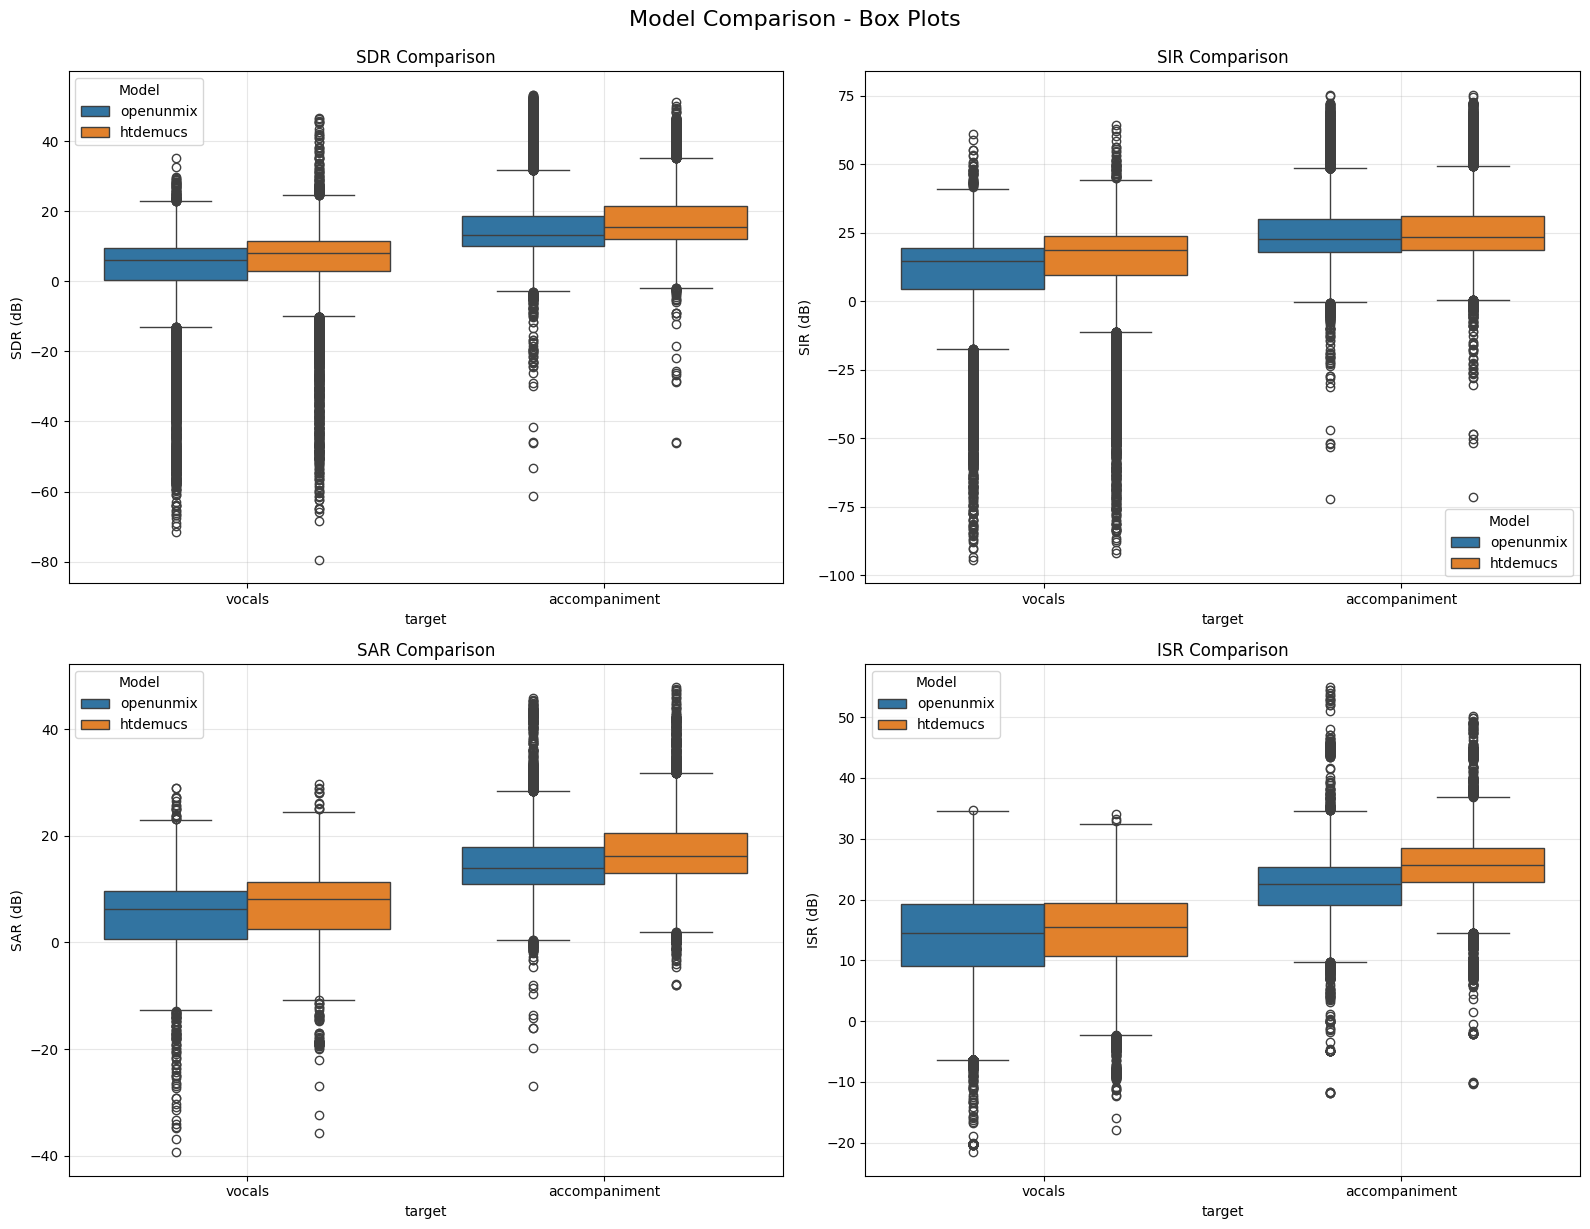

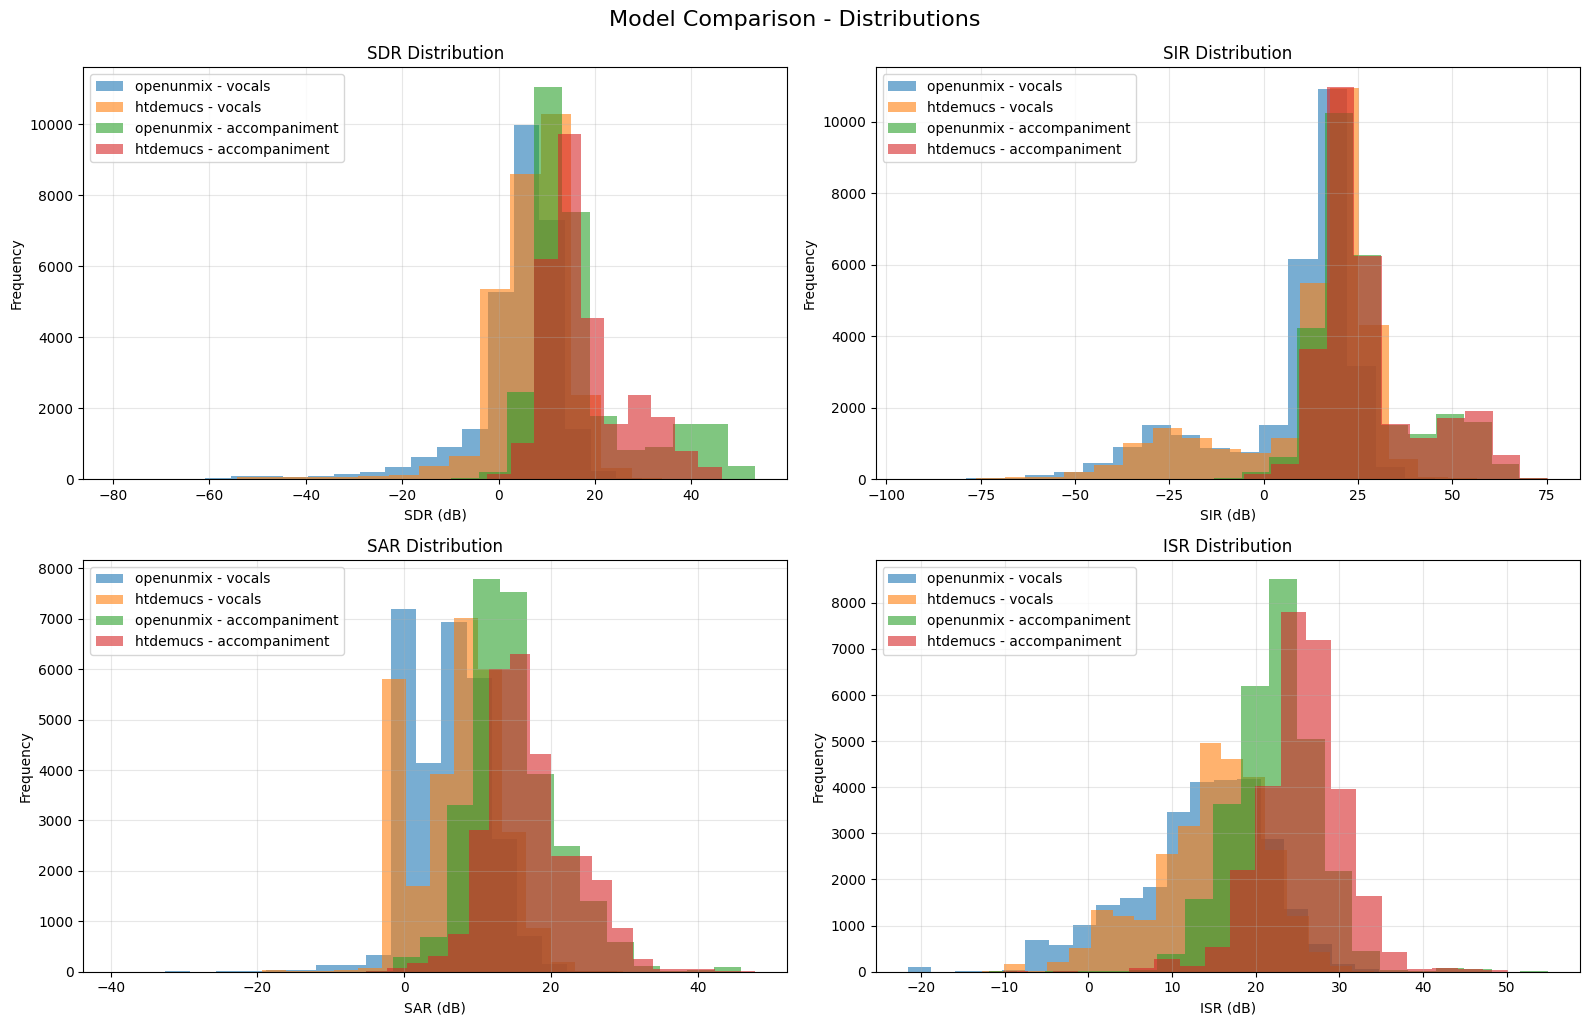

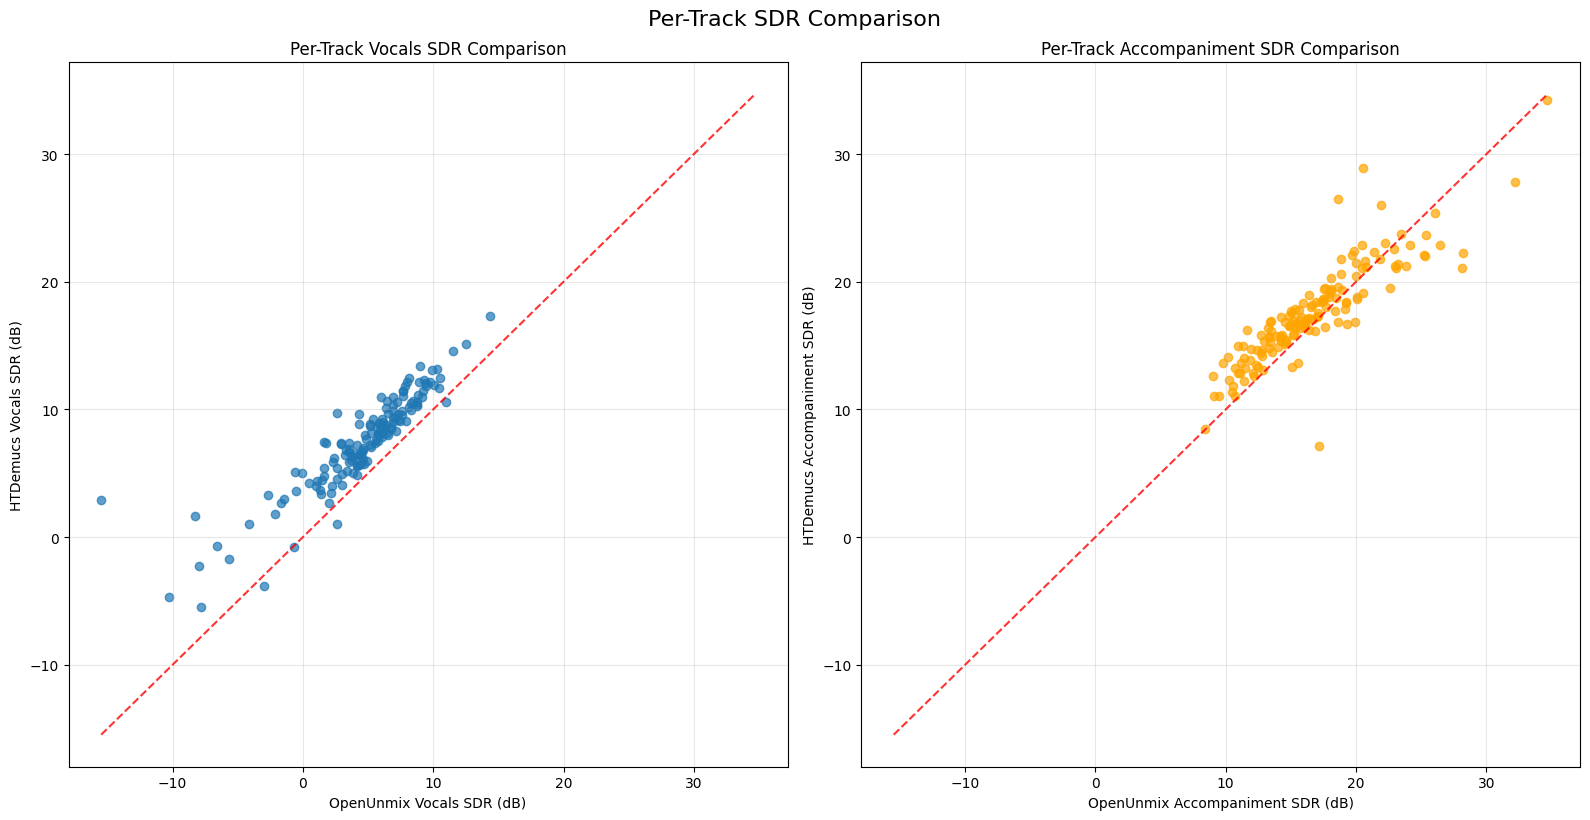

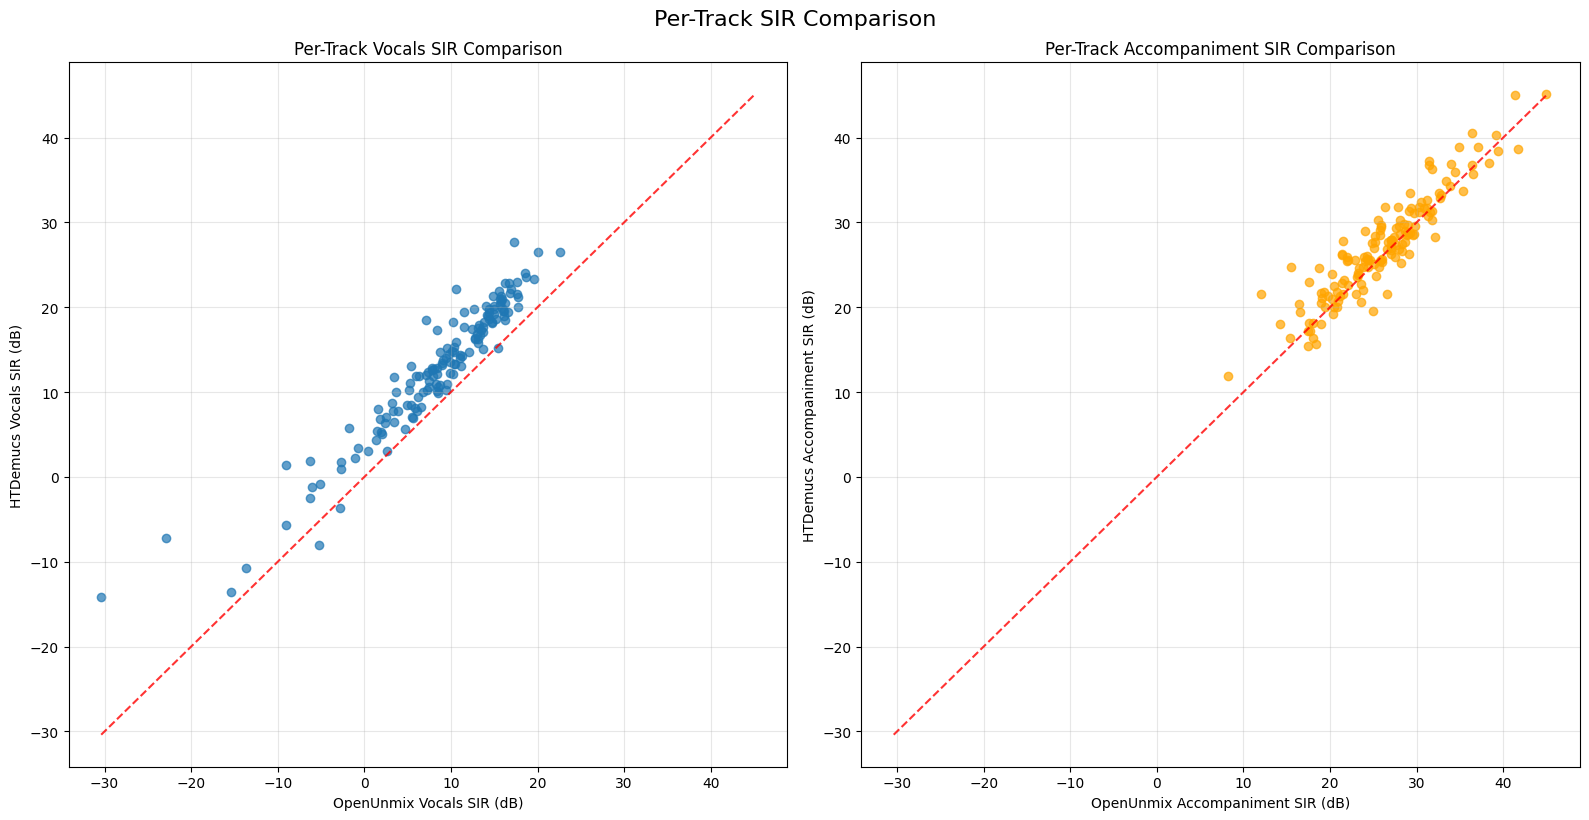

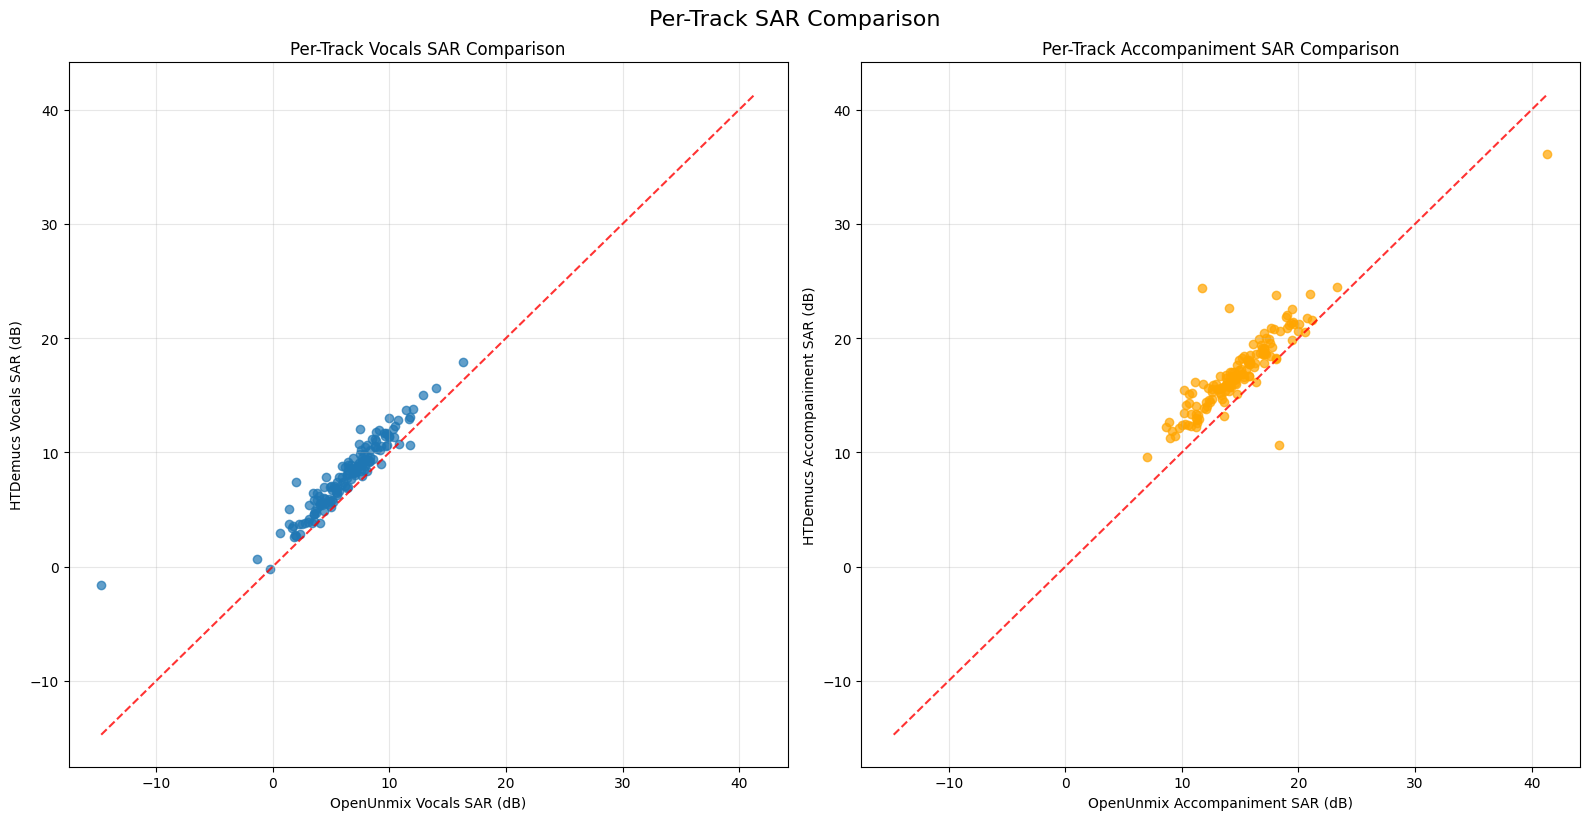


Comparison analysis complete!


In [8]:
df, stats_results, significance_results = generate_comparison_report(
    output_base_path=output_base_path,
    model_names=["openunmix", "htdemucs", "spleeter_2stems"],
)